In this notebook, we will compare the performance of NTKs and FC-NNs on the CIFAR10 dataset.  We begin by downloading and visualizing dataset samples below.

In [1]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor()])

path = '~/datasets/'

trainset = torchvision.datasets.CIFAR10(root=path,
                                        train=True,
                                        transform=transform,
                                        download=True)

testset = torchvision.datasets.CIFAR10(root=path,
                                        train=False,
                                        transform=transform,
                                        download=True)

Files already downloaded and verified
Files already downloaded and verified


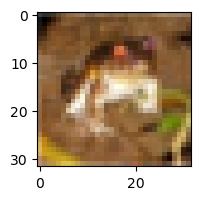

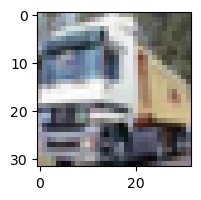

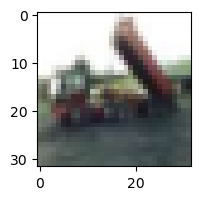

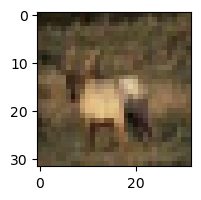

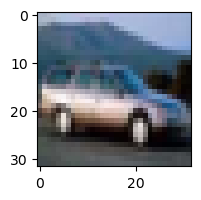

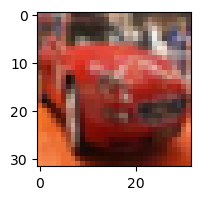

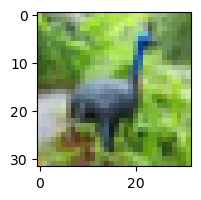

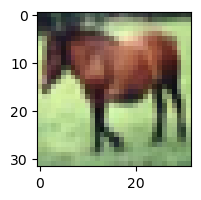

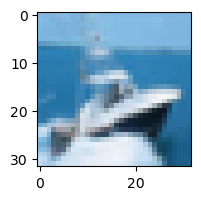

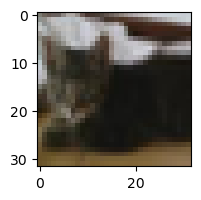

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_samples(trainset, indices):
    for idx in indices:
        img, label = trainset[idx]
        plt.figure(figsize=(2,2))
        plt.imshow(torch.permute(img, (1, 2, 0)))
        
visualize_samples(trainset, list(np.arange(10)))

CIFAR10 images are given as tensors of shape (3, 32, 32) and the labels are integers from $0$ through $9$ indicating different class labels.  For NTK of FCNNs, we want to "flatten" (reshape) the images to size $3072 = 3 \times 32 \times 32$.  We also want to convert the labels to one-hot vectors.  In this case, these vectors will be $10$ dimensional (since there are 10 classes) and will have a $1$ in the position corresponding to the class label.  For example, if the class label is $3$, then the one hot vector will be $\begin{bmatrix} 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \end{bmatrix}^T$ (remember that these are $0$-indexed). 

Below, we extract a subset of $5000$ training samples and use the full test set $10000$ test examples from CIFAR10. 

In [3]:
SEED = 1717
NUM_CLASSES = 10
np.random.seed(SEED)

def subset_indices(dataset, num_samples=1000):
    labelset = {}
    for i in range(NUM_CLASSES):
        one_hot = torch.zeros(NUM_CLASSES)
        one_hot[i] = 1
        labelset[i] = one_hot
        
    all_indices = list(np.arange(len(dataset)))
    subset_idxs = np.random.choice(all_indices, replace=False, size=num_samples) 
    Xs = []
    ys = []
    subset = []
    for idx in subset_idxs:
        img, label = dataset[idx]
        img = img.reshape(-1) 
        subset.append((img, labelset[label]))
        Xs.append(img)
        ys.append(labelset[label])
    return subset, np.stack(Xs), np.stack(ys)

train_subset, train_X, train_y = subset_indices(trainset, num_samples=5000)
test_subset, test_X, test_y = subset_indices(testset, num_samples=10000)

We verify that the shapes of training, test data are correct below. The training features should have shape (5000, 3072).  The test features should have shape (10000, 3072).  The training labels should have shape (5000, 10) and the test labels should have shape (10000, 10).

In [4]:
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(5000, 3072) (10000, 3072) (5000, 10) (10000, 10)


We now provide an API for calling the ReLU NTK.  While we provide the implementation for arbitrary depth, we will currently make use of the depth $2$ NTK (i.e., the NTK corresponding to a 1-hidden layer infinitely wide ReLU network).  

In [19]:
from numpy.linalg import solve

def relu_ntk(X, Z, depth=2, bias=0):
    from torch import acos
    pi = np.pi
    kappa_0 = lambda u: (1-acos(u)/pi)
    kappa_1 = lambda u: u*kappa_0(u) + (1-u.pow(2)).sqrt()/pi
    Z = Z if Z is not None else X
    eps = 0
    norm_x = X * X
    norm_x = torch.sqrt(torch.sum(norm_x, dim=1, keepdim=True))
    norm_z = Z * Z
    norm_z = torch.sqrt(torch.sum(norm_z, dim=1, keepdim=True).T)
    S = X @  Z.T

    N = S + bias**2

    for k in range(1, depth):
        in_ = (S/norm_x/norm_z).clip(-1+eps,1-eps)
        S = norm_x*norm_z*kappa_1(in_)
        N = N * kappa_0(in_) + S + bias**2
    return N, S

class ReLU_Kernel():

    def __init__(self, depth=2, bias=0, ntk=True):
        self.sol = None
        self.depth = depth
        self.X_train = None
        self.bias=bias
        self.ntk = ntk
        
    def fit(self, X, y, reg=0):
        self.X_train = torch.from_numpy(X)
        N, S = relu_ntk(self.X_train, self.X_train, bias=self.bias, depth=self.depth)
        if self.ntk:
            K = N.numpy()
        else: 
            K = S.numpy()
        sol = solve(K + reg * np.eye(len(K)), y).T
        self.sol = sol
        return self

    def predict(self, X):
        X = torch.from_numpy(X)
        N, S = relu_ntk(self.X_train, X, depth=self.depth, bias=self.bias)
        if self.ntk: 
            K = N.numpy()
        else:
            K = S.numpy()
        return (self.sol @ K).T

Below, we call our usual two lines for solving kernel regression.  

In [20]:
model = ReLU_Kernel(depth=2, ntk=True)
model.fit(train_X, train_y,)
train_pred = model.predict(train_X)
test_pred = model.predict(test_X)

We then compute the accuracy of the NTK on test data.  We should achieve a test accuracy of $44.88\%$.  

In [21]:
def get_acc(preds, labels):
    y_pred = np.argmax(preds, axis=-1)
    y_true = np.argmax(labels, axis=-1)
    return np.mean(y_pred == y_true)

train_acc = get_acc(train_pred, train_y)
test_acc = get_acc(test_pred, test_y)
print("Train Accuracy: ", str(round(train_acc*100, 2)) + '%')
print("Test Accuracy: ", str(round(test_acc*100, 2)) + '%')

Train Accuracy:  100.0%
Test Accuracy:  44.88%


We now compare performance against that of a 1 hidden layer fully connected network trained for 100 epochs using the MSE loss.  

In [136]:
from torch.utils.data import DataLoader

# Set up data loaders for training neural networks
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=1)
test_loader = DataLoader(test_subset, batch_size=128, shuffle=False, num_workers=1)

In [137]:
import torch.nn as nn
import torch.nn.functional as F

# I typically abstract away nonlinearity so that I can change it easily if needed
class Nonlinearity(nn.Module):
    def __init__(self):
        super(Nonlinearity, self).__init__()

    def forward(self, x):
        return F.relu(x)

# Build a simple 1 hidden layer FC net.  
class Net(nn.Module):

    def __init__(self, input_dim, target_dim):
        super(Net, self).__init__()
        bias = True
        k = 1024
        self.input_dim = input_dim
        self.target_dim = target_dim
        self.width = k
        self.fc = nn.Sequential(nn.Linear(input_dim, k, bias=bias),
                                Nonlinearity(),
                                nn.Linear(k, target_dim, bias=bias))

    def forward(self, x):
        return self.fc(x)

In [140]:
from torch.autograd import Variable
import torch.optim as optim
from tqdm import tqdm 

def train_network(trainloader, testloader, num_epochs=100):

    for idx, batch in enumerate(train_loader):
        inputs, labels = batch
        _, input_dim = inputs.shape
        _, output_dim = labels.shape
        break
    
    net = Net(input_dim, output_dim)
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
    
    train_losses = []
    test_losses = []
    
    for t in tqdm(range(num_epochs)):
        train_loss = train_step(net, optimizer, train_loader)
        test_loss = test_step(net, test_loader)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    return net, train_losses, test_losses
        
def train_step(net, optimizer, train_loader):
    net.train()
    criterion = torch.nn.MSELoss(reduction='mean')
    train_loss = 0.
    for batch_idx, batch in enumerate(train_loader):    
        optimizer.zero_grad()
        inputs, targets = batch 
        output = net(Variable(inputs))
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().data.numpy() * len(inputs)
    train_loss = train_loss / len(train_loader.dataset)
    return train_loss

def test_step(net, test_loader):
    net.eval()
    criterion = torch.nn.MSELoss(reduction='mean')
    test_loss = 0.
    for batch_idx, batch in enumerate(test_loader):    
        inputs, targets = batch 
        with torch.no_grad():
            output = net(Variable(inputs))
        loss = criterion(output, targets)
        test_loss += loss.cpu().data.numpy() * len(inputs)
    test_loss = test_loss / len(test_loader.dataset)
    return test_loss

In [151]:
num_epochs = 100
net, train_losses, test_losses = train_network(train_loader, test_loader, num_epochs=num_epochs)

100%|███████████████████████████████████████████████████████| 100/100 [02:14<00:00,  1.34s/it]


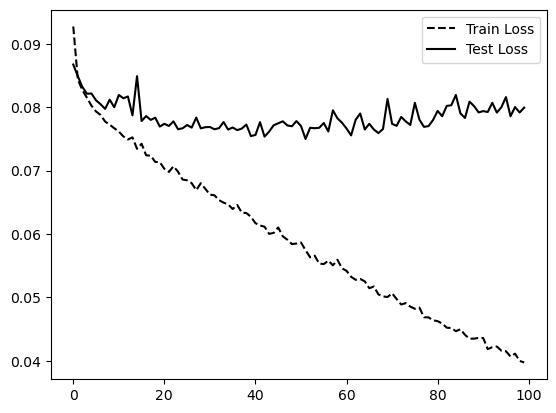

In [152]:
epochs = list(range(num_epochs))
plt.plot(epochs, train_losses, 'k--', label='Train Loss')
plt.plot(epochs, test_losses, 'k-', label='Test Loss')
plt.legend()
plt.show()

In [153]:
@torch.no_grad()
def get_nn_acc(net, loader):
    acc = 0.
    for idx, batch in enumerate(loader):
        inputs, labels = batch
        out = net(inputs)
        acc += torch.sum(torch.argmax(out, axis=-1) == torch.argmax(labels, axis=-1)).data.numpy().item()
    return acc / len(loader.dataset)
        
train_acc = get_nn_acc(net, train_loader)
test_acc = get_nn_acc(net, test_loader)

print("NN Train Accuracy: ", str(round(train_acc*100, 2)) + '%')
print("NN Test Accuracy: ", str(round(test_acc*100, 2)) + '%')

NN Train Accuracy:  86.18%
NN Test Accuracy:  43.16%
